# --- Import Libraries ---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Data Loading ---

In [2]:
# The main data file is 'data.csv' and is located in the 'data/raw/' directory.
# Xente_Variable_Definitions.csv/.xlsx can be used for understanding column meanings.
try:
    df_train = pd.read_csv('../data/raw/data.csv')
    print("Data loaded successfully from data.csv.")
except FileNotFoundError:
    print("Data file 'data.csv' not found. Please ensure it is in 'data/raw/'.")
    print("Creating dummy dataframe for demonstration purposes.")
    # Create dummy dataframe for demonstration if file is not found
    data_train = {
        'TransactionId': range(1000),
        'BatchId': np.random.randint(1, 50, 1000),
        'AccountId': np.random.randint(100, 500, 1000),
        'SubscriptionId': np.random.randint(1, 100, 1000),
        'CustomerId': np.random.randint(100, 500, 1000),
        'CurrencyCode': np.random.choice(['KES', 'USD', 'UGX'], 1000),
        'CountryCode': np.random.randint(250, 300, 1000),
        'ProviderId': np.random.randint(1, 10, 1000),
        'ProductId': np.random.randint(1000, 1020, 1000),
        'ProductCategory': np.random.choice(['Electronics', 'Groceries', 'Fashion', 'Services'], 1000),
        'ChannelId': np.random.choice(['Web', 'Android', 'IOS', 'PayLater'], 1000),
        'Amount': np.random.uniform(-10000, 50000, 1000),
        'Value': np.abs(np.random.uniform(-10000, 50000, 1000)),
        'TransactionStartTime': pd.to_datetime('2024-01-01') + pd.to_timedelta(np.random.randint(0, 365, 1000), unit='D'),
        'PricingStrategy': np.random.randint(0, 5, 1000),
        'FraudResult': np.random.choice([0, 1], 1000, p=[0.99, 0.01]) # Simulate imbalance
    }
    df_train = pd.DataFrame(data_train)
    df_train['TransactionStartTime'] = pd.to_datetime(df_train['TransactionStartTime'])

Data loaded successfully from data.csv.


# --- 1. Overview of the Data ---

In [3]:
print("\n--- Data Overview (Training Data) ---")
print("Shape:", df_train.shape)
print("\nFirst 5 rows:")
print(df_train.head())
print("\nData types:")
print(df_train.info())


--- Data Overview (Training Data) ---
Shape: (95662, 16)

First 5 rows:
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6

# --- 2. Summary Statistics ---

In [4]:
print("\n--- Summary Statistics (Numerical Features) ---")
print(df_train.describe())


--- Summary Statistics (Numerical Features) ---
       CountryCode        Amount         Value  PricingStrategy   FraudResult
count      95662.0  9.566200e+04  9.566200e+04     95662.000000  95662.000000
mean         256.0  6.717846e+03  9.900584e+03         2.255974      0.002018
std            0.0  1.233068e+05  1.231221e+05         0.732924      0.044872
min          256.0 -1.000000e+06  2.000000e+00         0.000000      0.000000
25%          256.0 -5.000000e+01  2.750000e+02         2.000000      0.000000
50%          256.0  1.000000e+03  1.000000e+03         2.000000      0.000000
75%          256.0  2.800000e+03  5.000000e+03         2.000000      0.000000
max          256.0  9.880000e+06  9.880000e+06         4.000000      1.000000


# --- 3. Distribution of Numerical Features ---


--- Distribution of Numerical Features ---


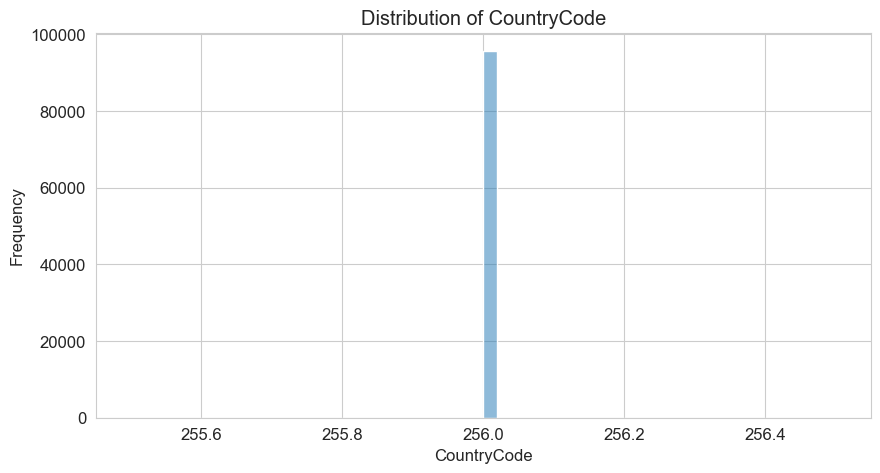

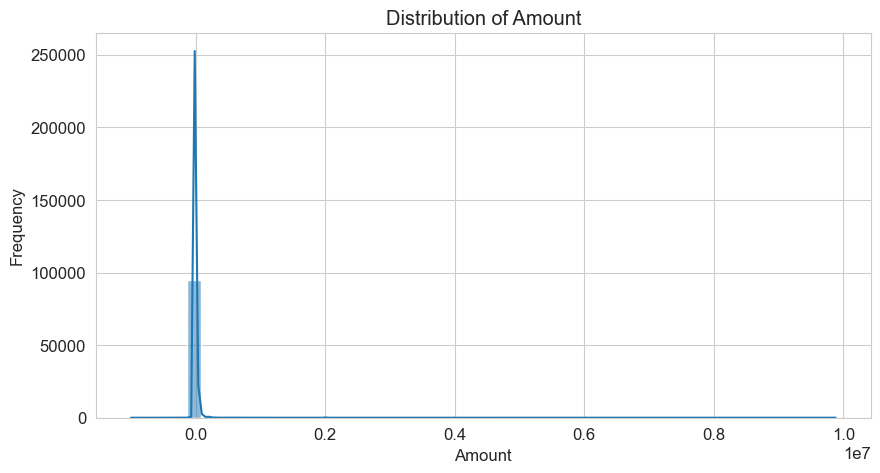

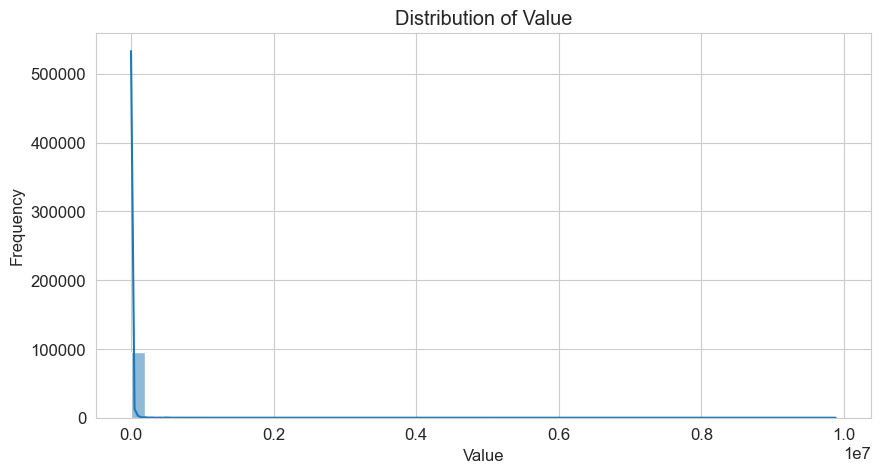

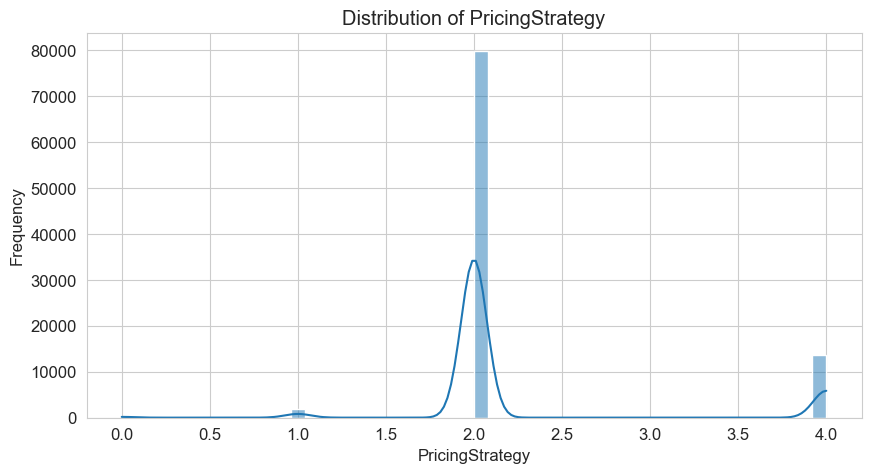

In [5]:
print("\n--- Distribution of Numerical Features ---")
numerical_features = df_train.select_dtypes(include=np.number).columns.tolist()
# Exclude IDs and FraudResult for general distribution plots
numerical_features_to_plot = [col for col in numerical_features if 'Id' not in col and col != 'FraudResult']

for col in numerical_features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_train[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

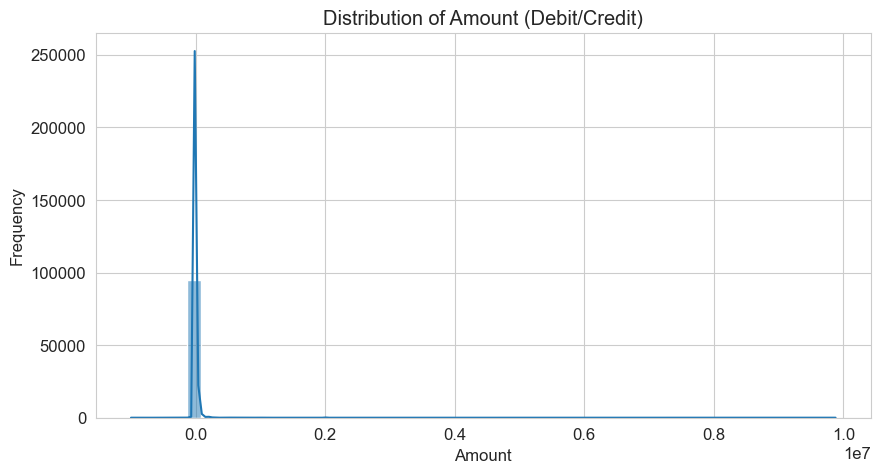

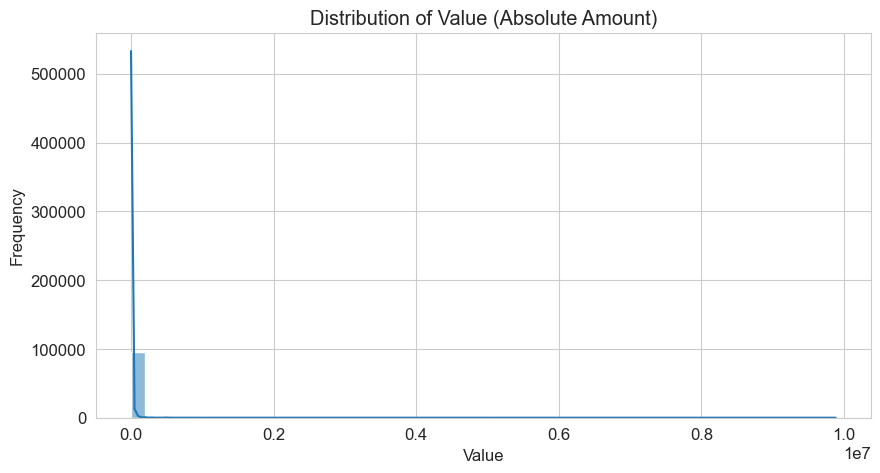

In [6]:
# Special look at 'Amount' and 'Value' due to their nature (debits/credits vs. absolute)
plt.figure(figsize=(10, 5))
sns.histplot(df_train['Amount'], kde=True, bins=50)
plt.title('Distribution of Amount (Debit/Credit)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_train['Value'], kde=True, bins=50)
plt.title('Distribution of Value (Absolute Amount)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

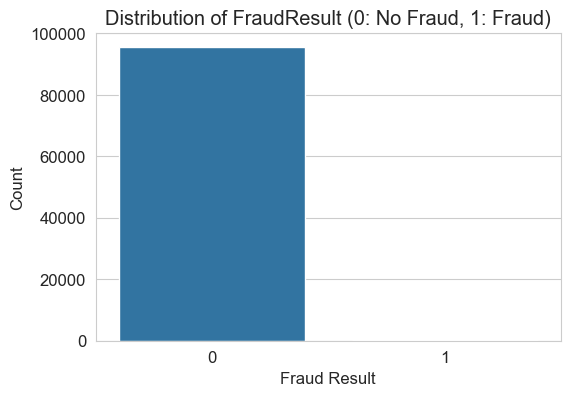


Fraudulent transactions (FraudResult=1): 0.20%
Non-fraudulent transactions (FraudResult=0): 99.80%


In [7]:
# Distribution of FraudResult (our proxy target)
plt.figure(figsize=(6, 4))
sns.countplot(x='FraudResult', data=df_train)
plt.title('Distribution of FraudResult (0: No Fraud, 1: Fraud)')
plt.xlabel('Fraud Result')
plt.ylabel('Count')
plt.show()
fraud_percentage = df_train['FraudResult'].value_counts(normalize=True) * 100
print(f"\nFraudulent transactions (FraudResult=1): {fraud_percentage[1]:.2f}%")
print(f"Non-fraudulent transactions (FraudResult=0): {fraud_percentage[0]:.2f}%")

# --- 4. Distribution of Categorical Features ---


--- Distribution of Categorical Features ---


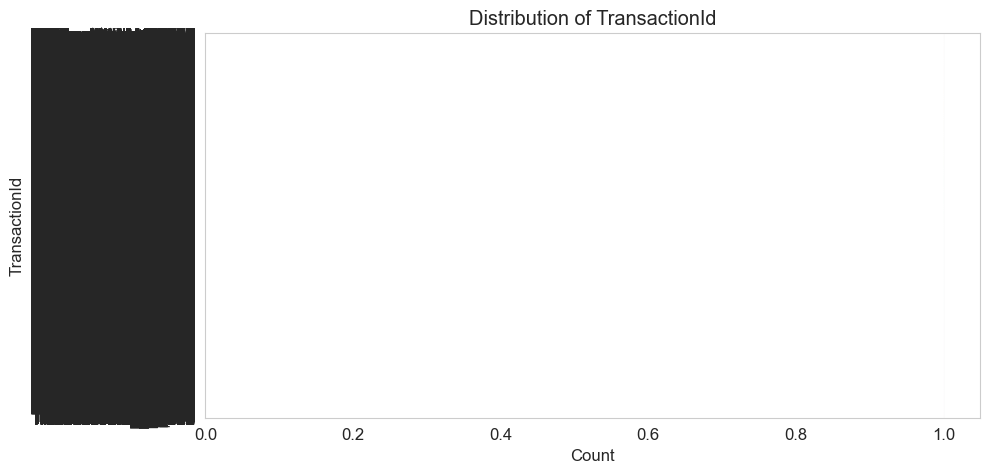

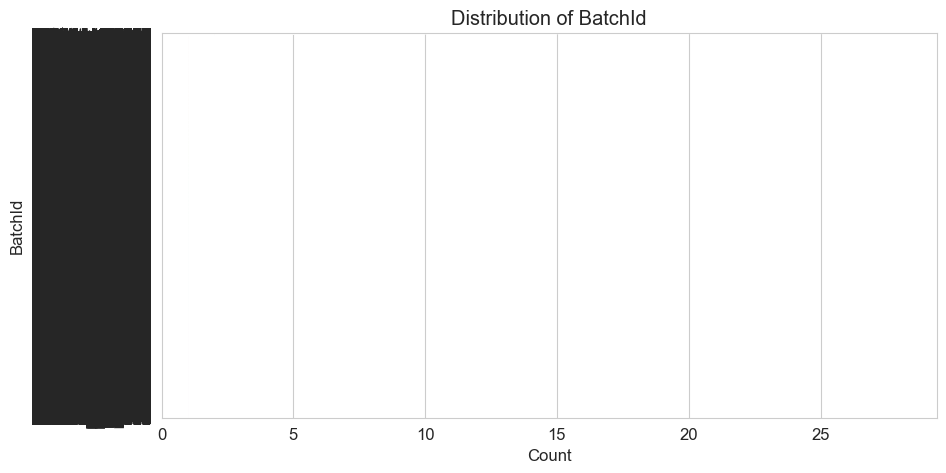

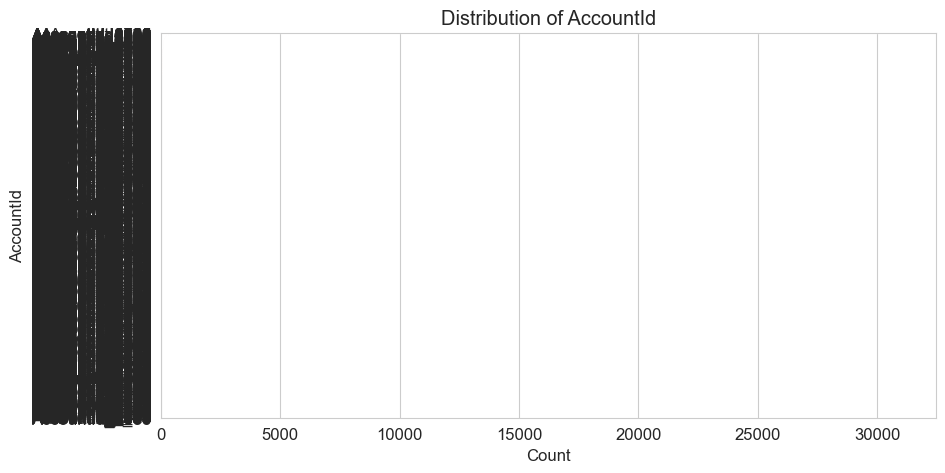

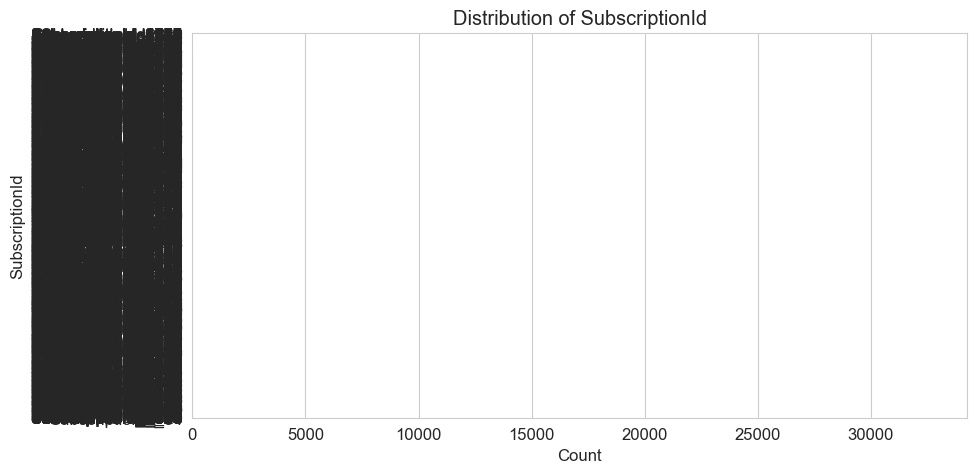

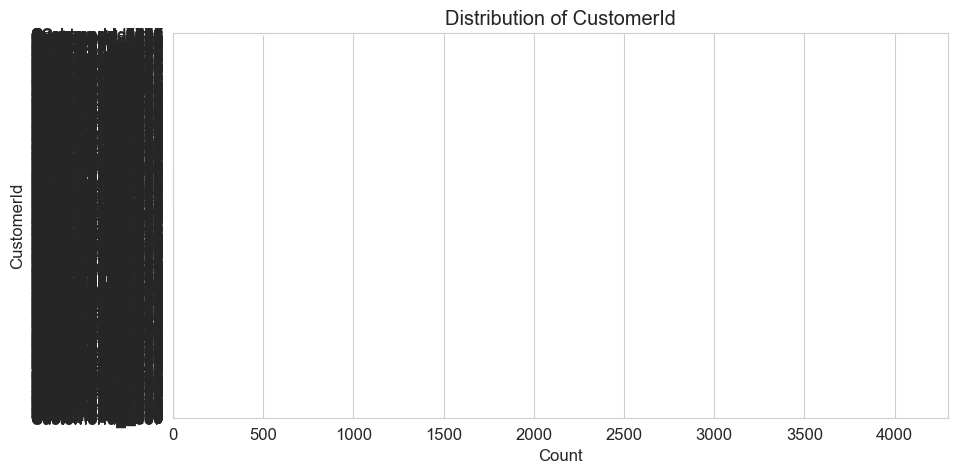

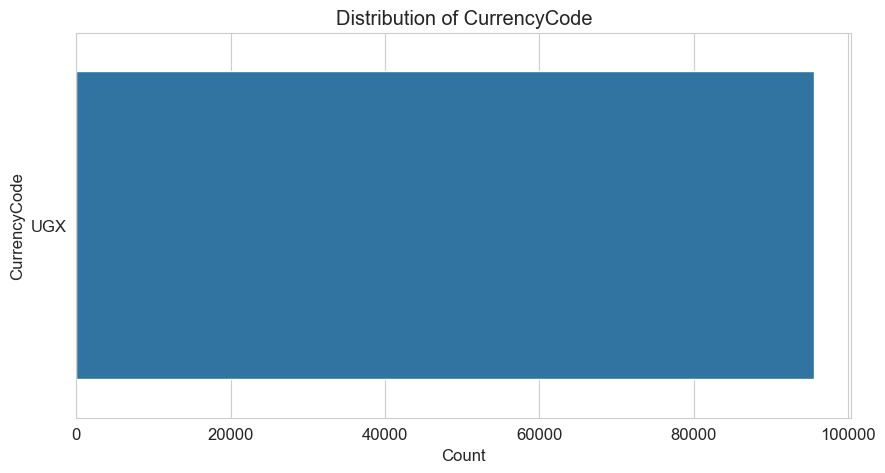

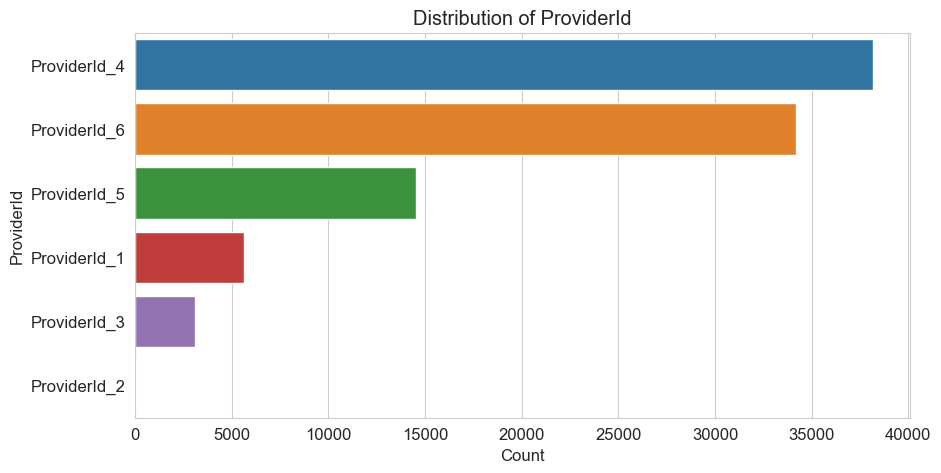

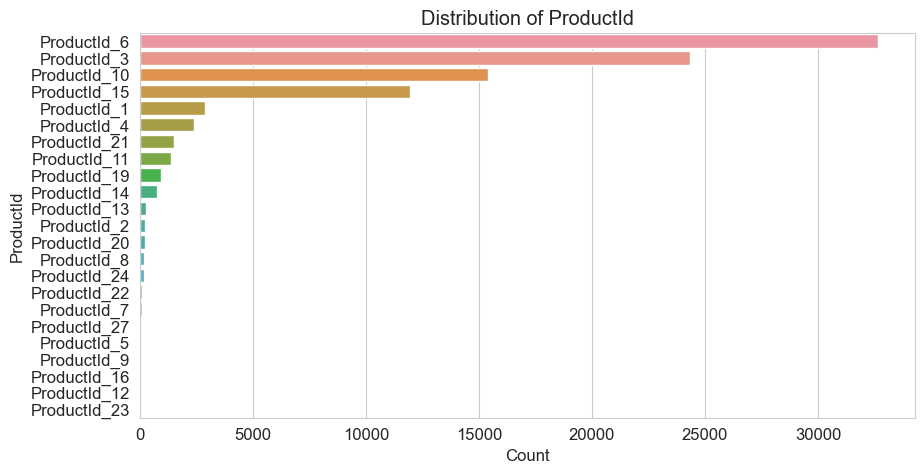

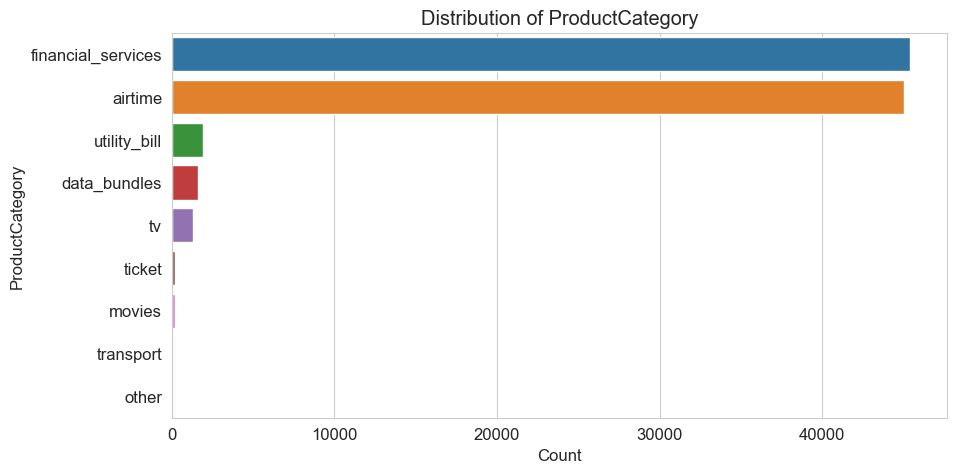

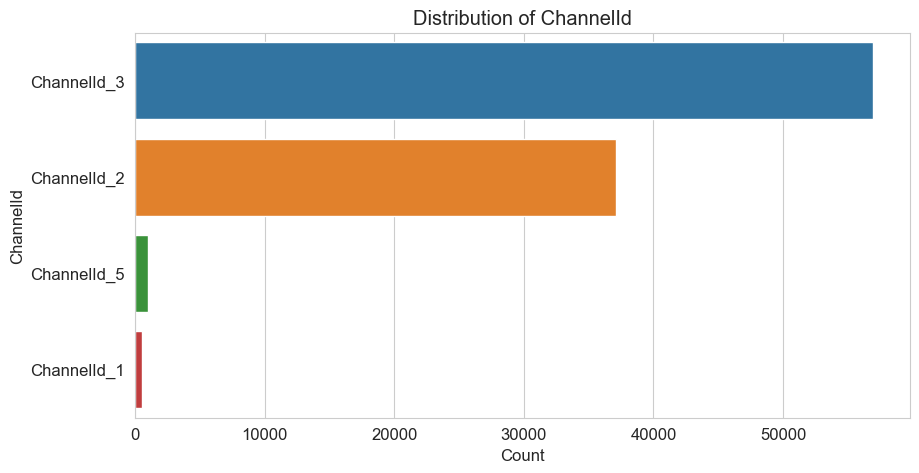

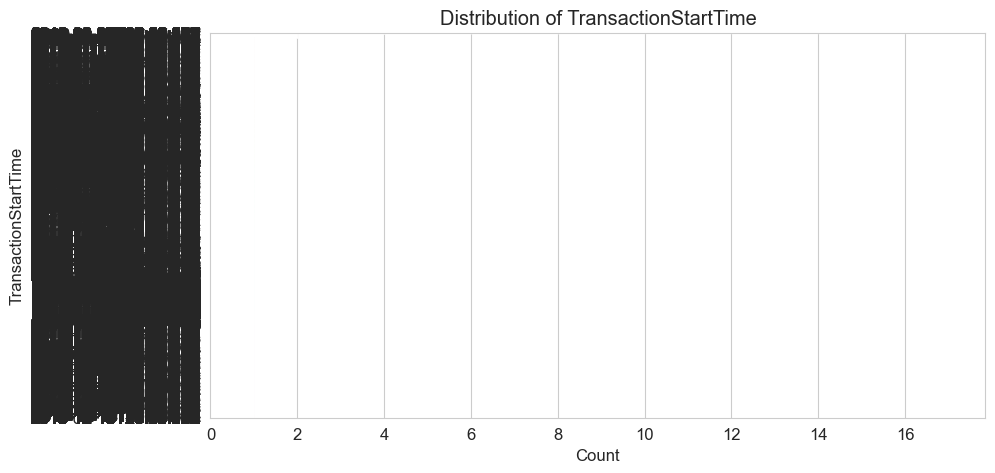

In [8]:
print("\n--- Distribution of Categorical Features ---")
categorical_features = df_train.select_dtypes(include='object').columns.tolist()

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

C:\Users\benke\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


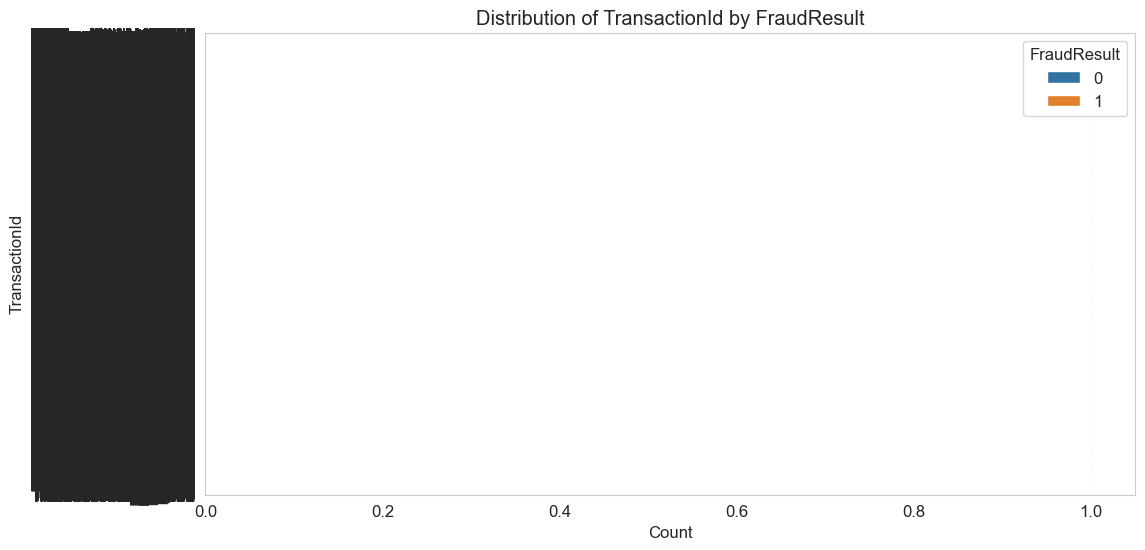

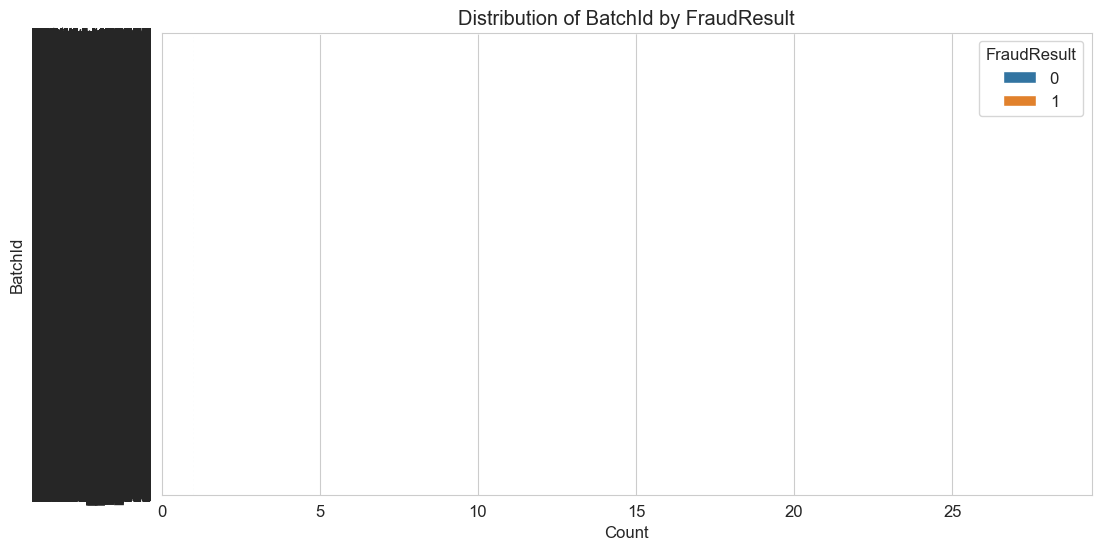

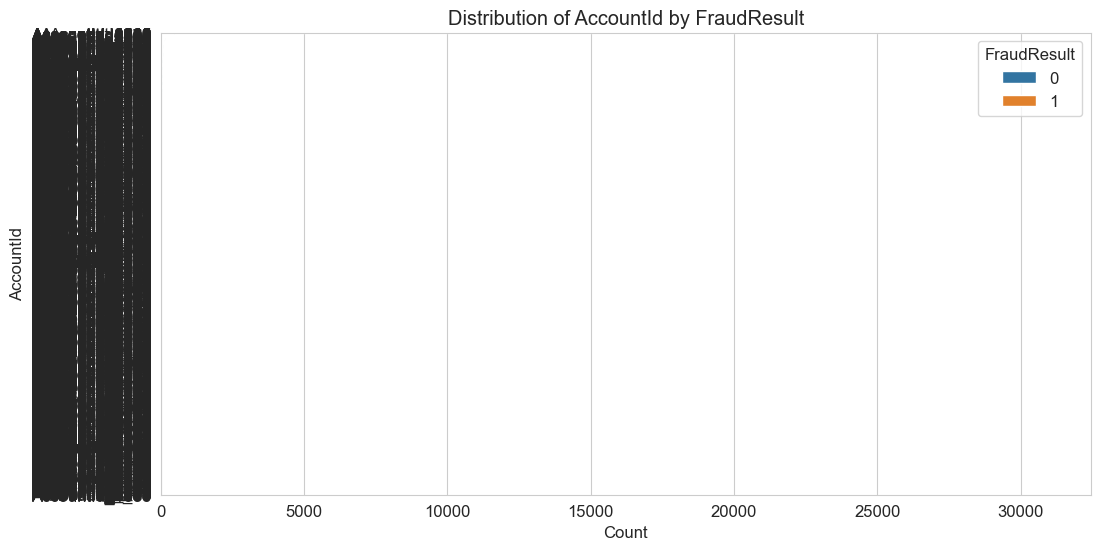

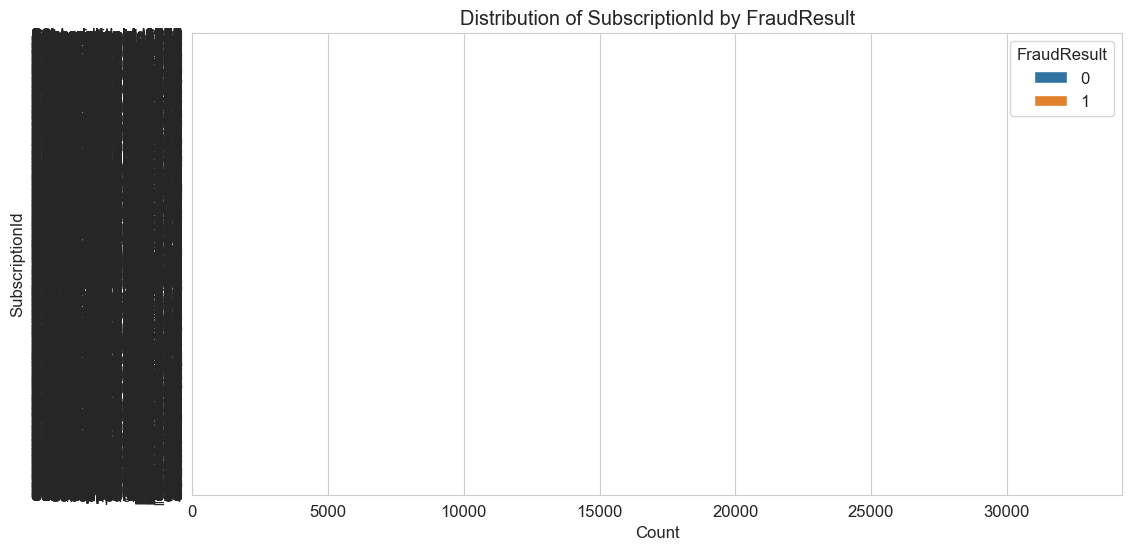

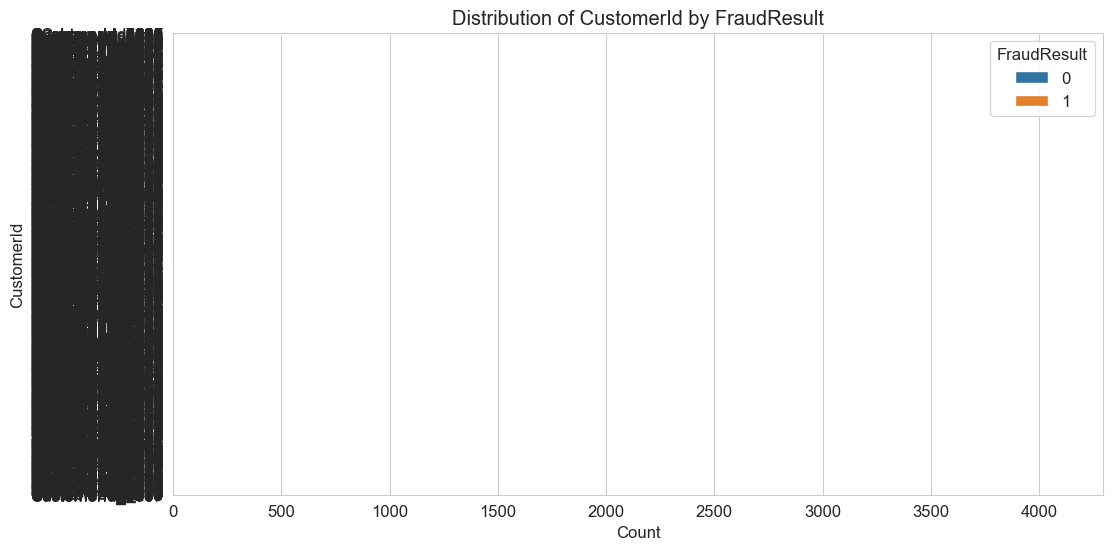

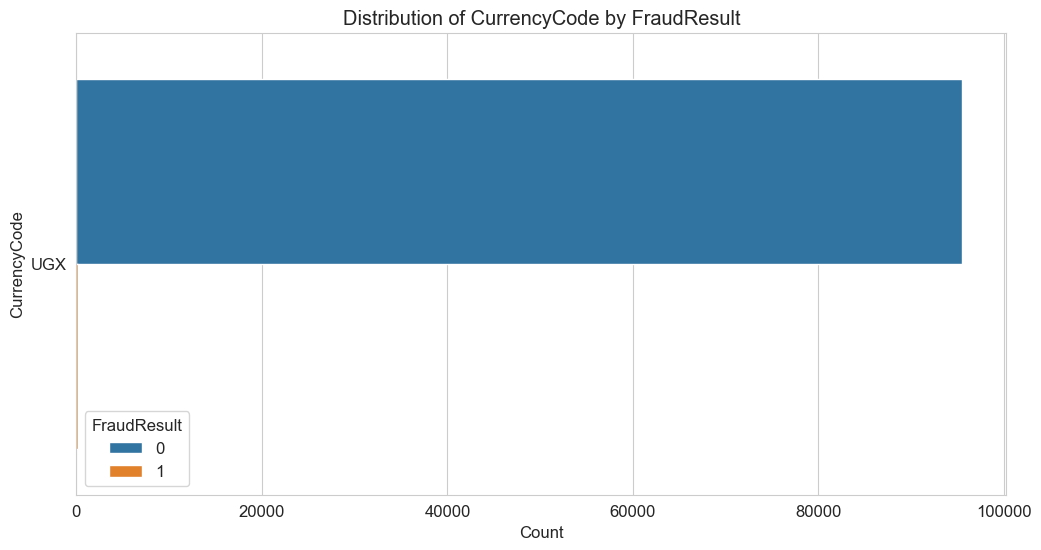

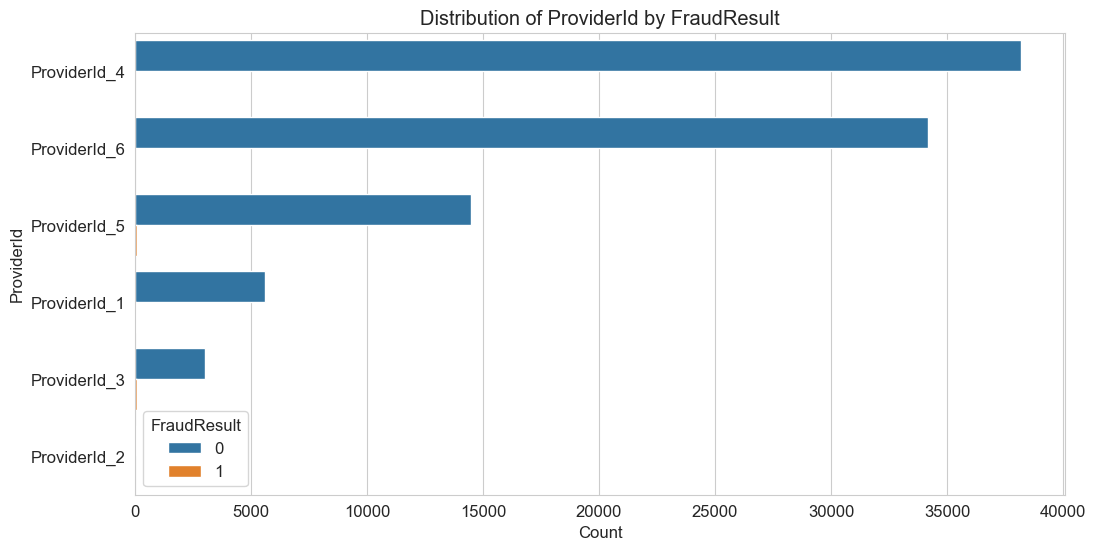

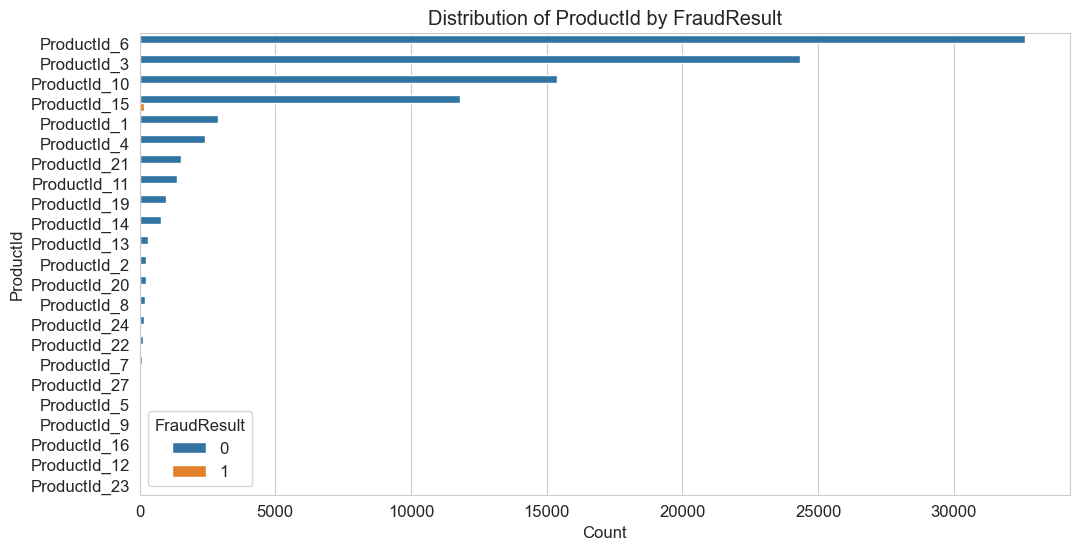

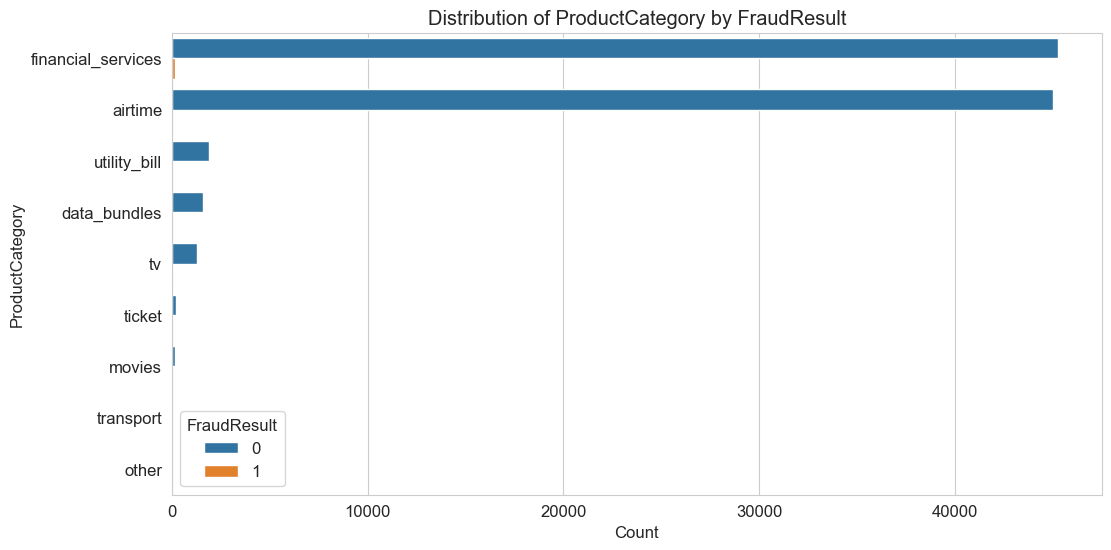

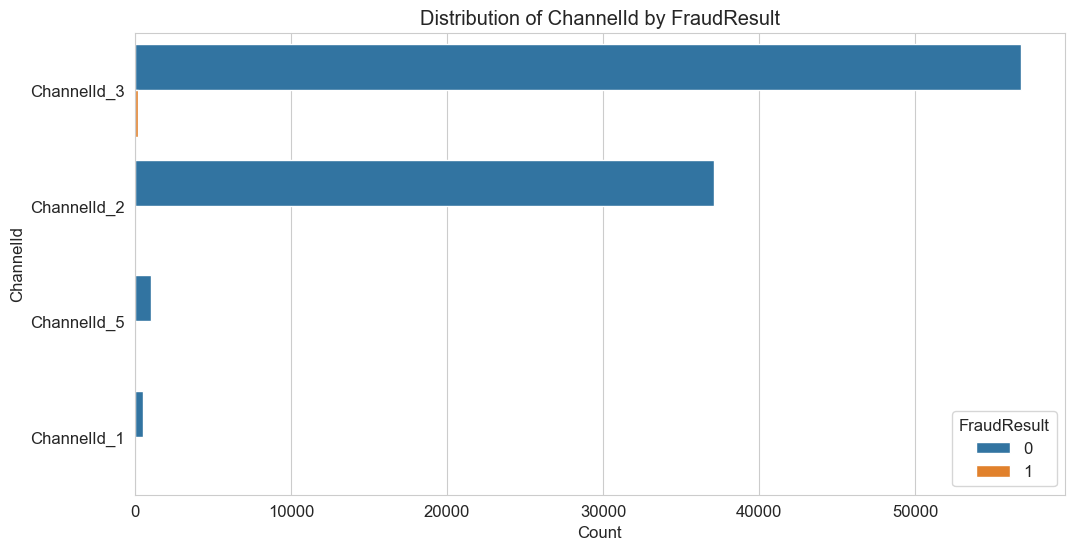

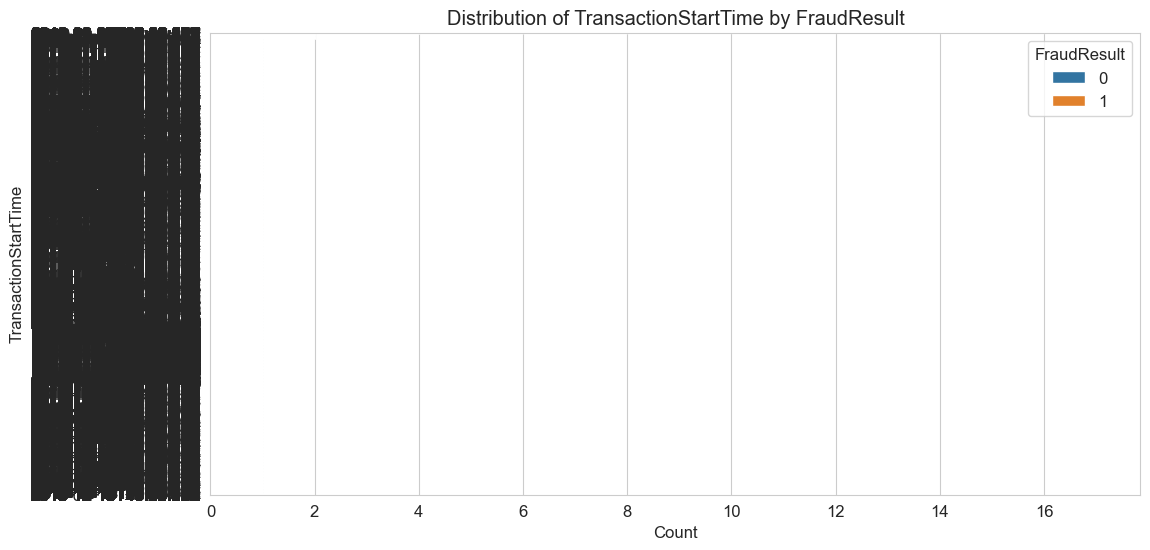

In [9]:
# Analyze categorical features in relation to FraudResult
for col in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=col, hue='FraudResult', data=df_train,
                  order=df_train[col].value_counts().index)
    plt.title(f'Distribution of {col} by FraudResult')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.legend(title='FraudResult')
    plt.show()

# --- 5. Correlation Analysis ---


--- Correlation Analysis (Numerical Features) ---


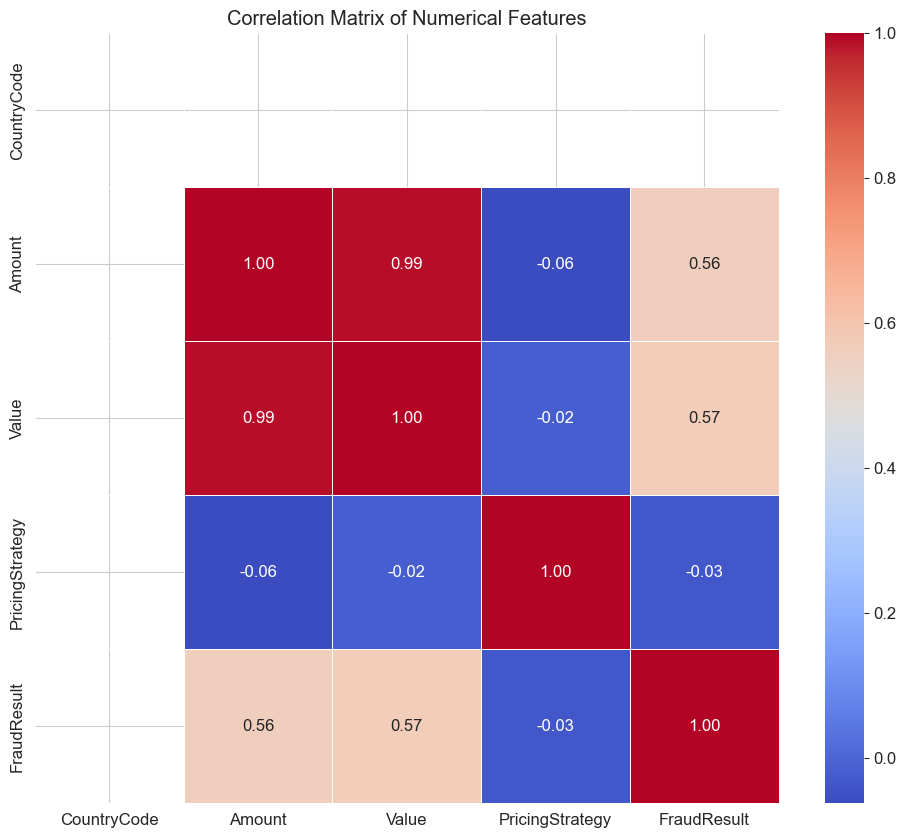


Correlation of Numerical Features with FraudResult:
FraudResult        1.000000
Value              0.566739
Amount             0.557370
PricingStrategy   -0.033821
CountryCode             NaN
Name: FraudResult, dtype: float64


In [10]:
print("\n--- Correlation Analysis (Numerical Features) ---")
# Calculate correlation matrix for numerical features
corr_matrix = df_train[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Correlation with FraudResult specifically
print("\nCorrelation of Numerical Features with FraudResult:")
print(df_train[numerical_features].corr()['FraudResult'].sort_values(ascending=False))

# --- 6. Identifying Missing Values ---

In [11]:
print("\n--- Missing Values Analysis ---")
missing_values = df_train.isnull().sum()
missing_percentage = (df_train.isnull().sum() / len(df_train)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percentage})
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False))

if missing_df[missing_df['Missing Count'] > 0].empty:
    print("No missing values found in the training dataset.")


--- Missing Values Analysis ---
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []
No missing values found in the training dataset.


# --- 7. Outlier Detection ---


--- Outlier Detection (Numerical Features) ---


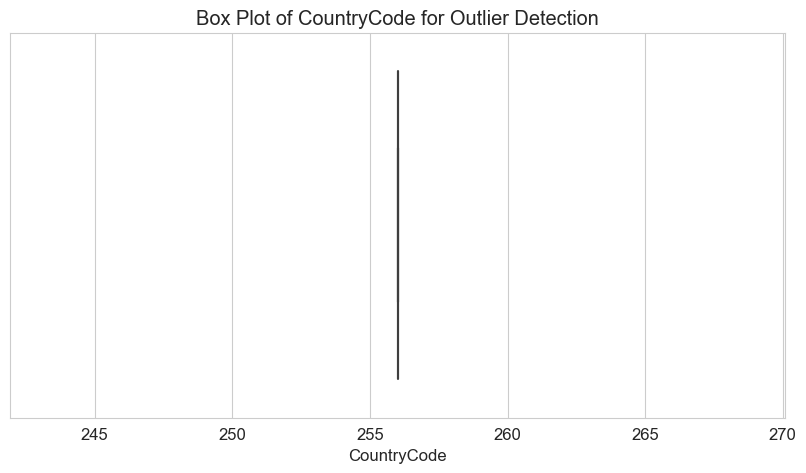

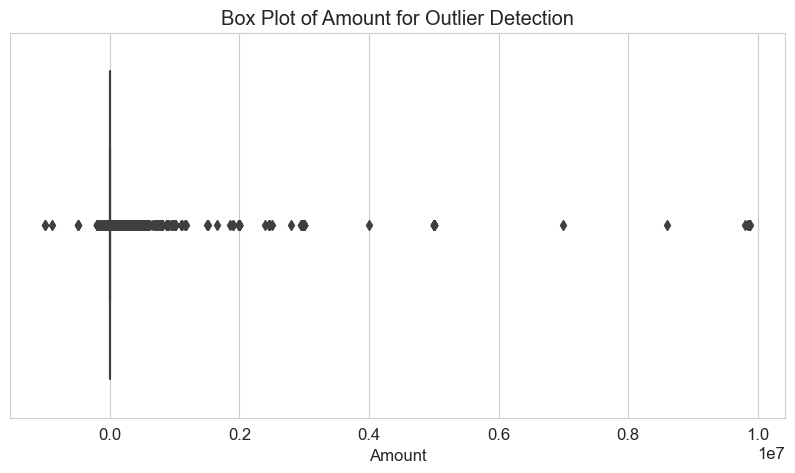

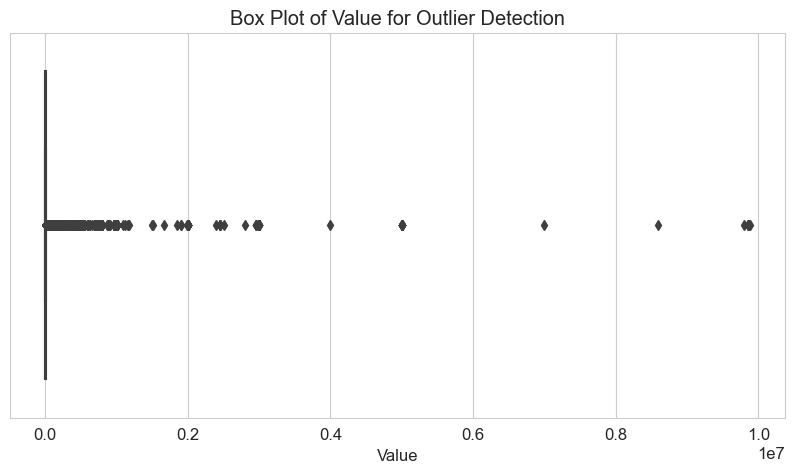

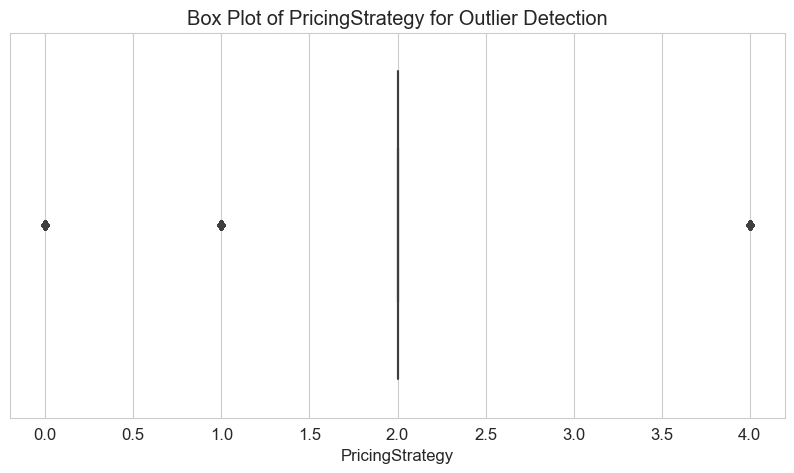

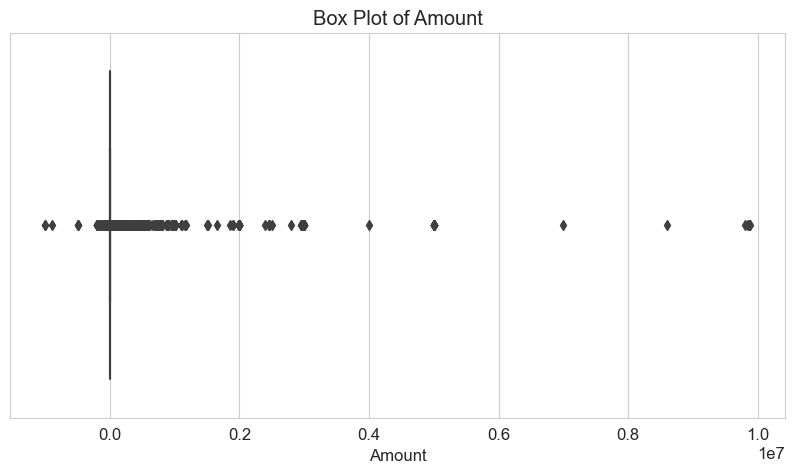

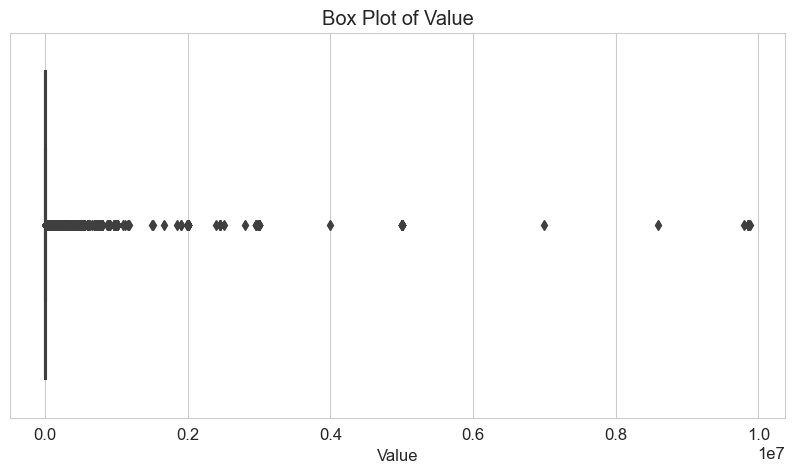

In [12]:
print("\n--- Outlier Detection (Numerical Features) ---")
for col in numerical_features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_train[col])
    plt.title(f'Box Plot of {col} for Outlier Detection')
    plt.xlabel(col)
    plt.show()

# Box plot for Amount and Value
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_train['Amount'])
plt.title('Box Plot of Amount')
plt.xlabel('Amount')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_train['Value'])
plt.title('Box Plot of Value')
plt.xlabel('Value')
plt.show()

# --- Additional EDA for Credit Risk Modeling ---

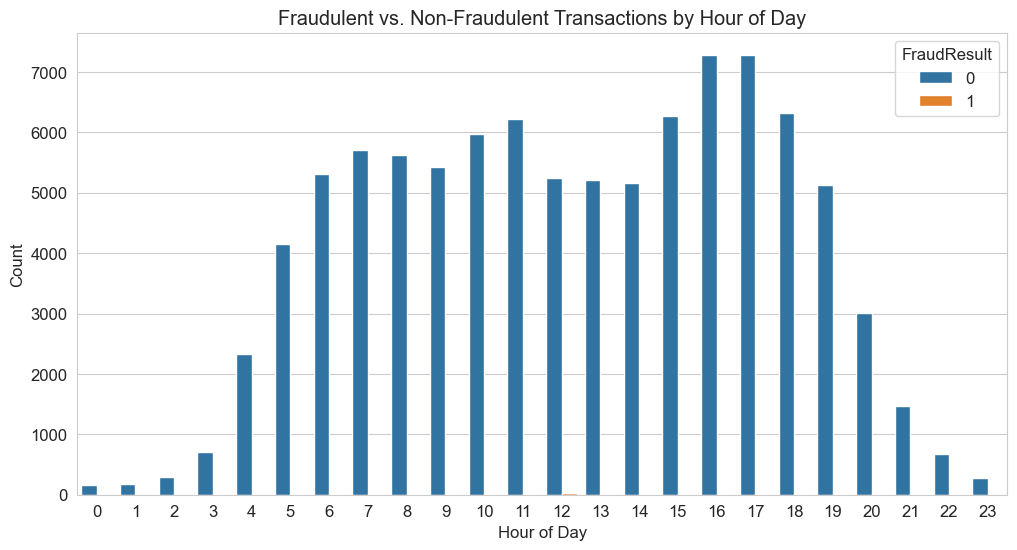

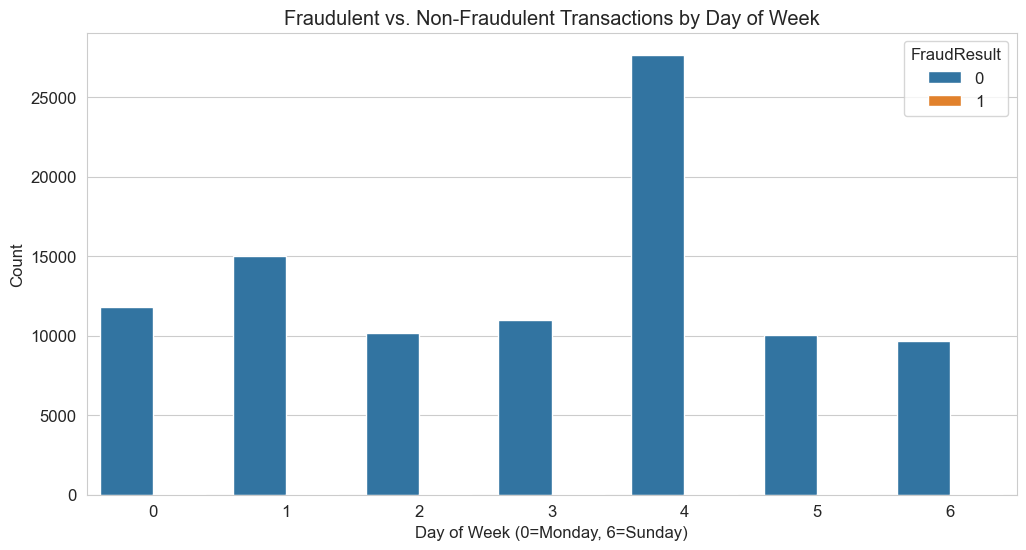

In [13]:
# Convert TransactionStartTime to datetime and extract time-based features
df_train['TransactionStartTime'] = pd.to_datetime(df_train['TransactionStartTime'])
df_train['TransactionHour'] = df_train['TransactionStartTime'].dt.hour
df_train['TransactionDayOfWeek'] = df_train['TransactionStartTime'].dt.dayofweek
df_train['TransactionMonth'] = df_train['TransactionStartTime'].dt.month

# Analyze fraud by hour of day
plt.figure(figsize=(12, 6))
sns.countplot(x='TransactionHour', hue='FraudResult', data=df_train)
plt.title('Fraudulent vs. Non-Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

# Analyze fraud by day of week
plt.figure(figsize=(12, 6))
sns.countplot(x='TransactionDayOfWeek', hue='FraudResult', data=df_train)
plt.title('Fraudulent vs. Non-Fraudulent Transactions by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.show()

# Aggregate data to customer level for RFM and fraud status

In [14]:
# For Recency, we need a 'current date' reference. Let's use the max transaction time in the dataset.
current_date = df_train['TransactionStartTime'].max()

customer_data = df_train.groupby('AccountId').agg(
    Recency=('TransactionStartTime', lambda date: (current_date - date.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Value', 'sum'),
    TotalFraudTransactions=('FraudResult', 'sum'),
    HasFraud=('FraudResult', lambda x: 1 if x.sum() > 0 else 0), # Our proxy target
    AvgAmount=('Amount', 'mean'),
    MaxValue=('Value', 'max'),
    UniqueProductCategories=('ProductCategory', 'nunique'),
    UniqueChannels=('ChannelId', 'nunique')
).reset_index()

print("\n--- Customer-level Aggregated Data Sample ---")
print(customer_data.head())
print("\nDistribution of HasFraud (Customer Level):")
print(customer_data['HasFraud'].value_counts(normalize=True) * 100)


--- Customer-level Aggregated Data Sample ---
        AccountId  Recency  Frequency  Monetary  TotalFraudTransactions  \
0     AccountId_1       34          3     70000                       0   
1    AccountId_10        0        965   3404267                       0   
2   AccountId_100       37          2    180000                       0   
3  AccountId_1000       79         10     97000                       0   
4  AccountId_1002       21          1   2000000                       0   

   HasFraud     AvgAmount  MaxValue  UniqueProductCategories  UniqueChannels  
0         0  2.333333e+04     30000                        1               1  
1         0 -3.451137e+03     14999                        5               1  
2         0  9.000000e+04    100000                        1               1  
3         0  9.700000e+03     50000                        2               1  
4         0  2.000000e+06   2000000                        1               1  

Distribution of HasFraud (C

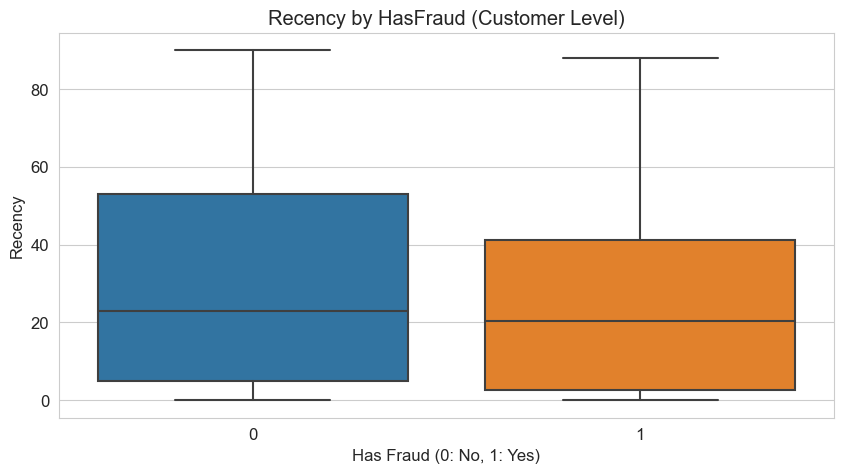

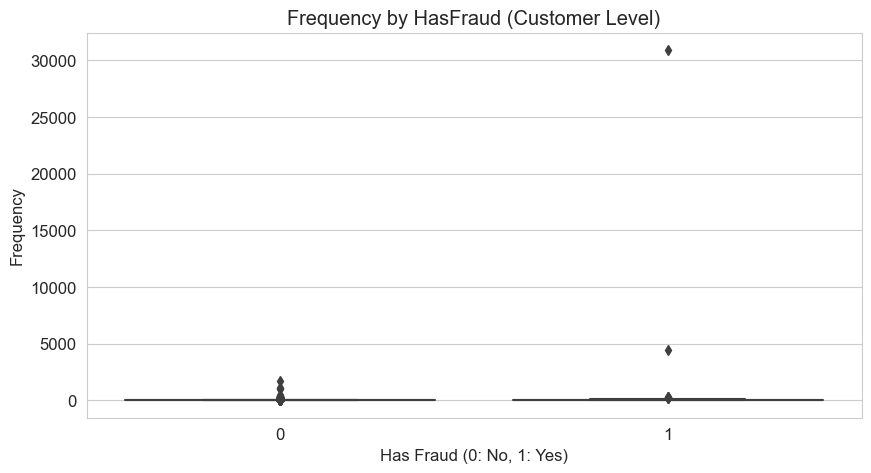

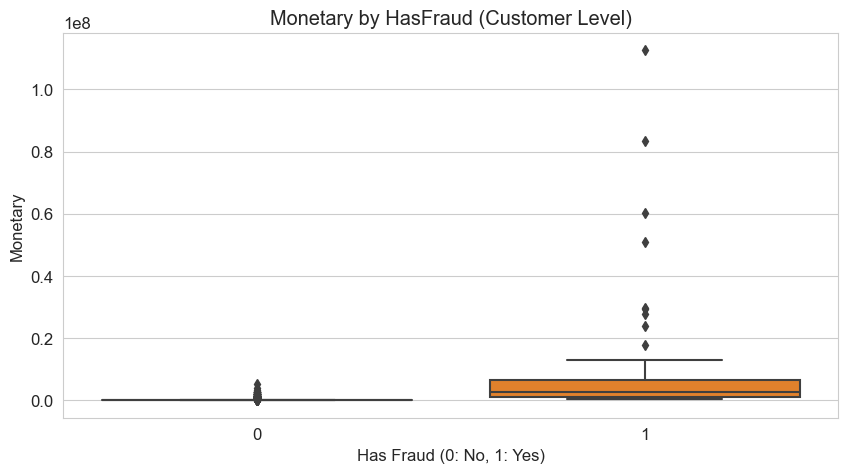

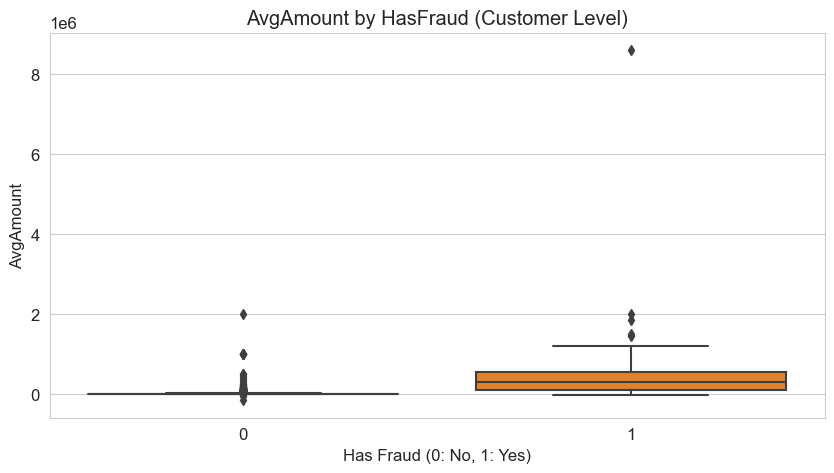

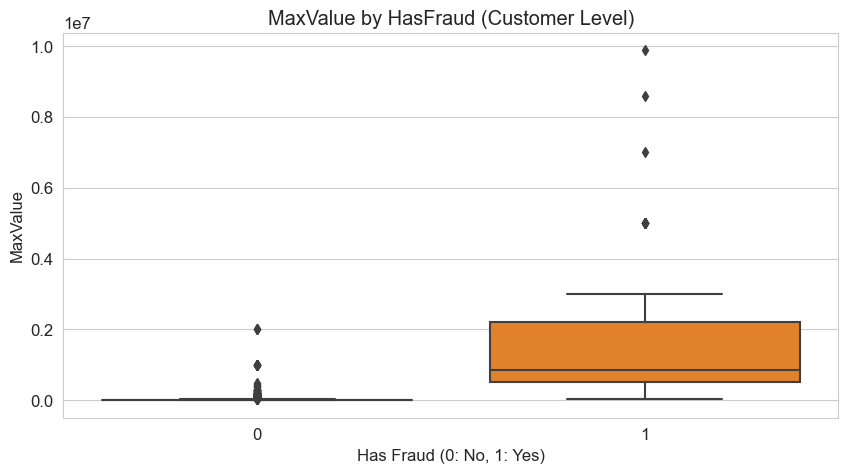

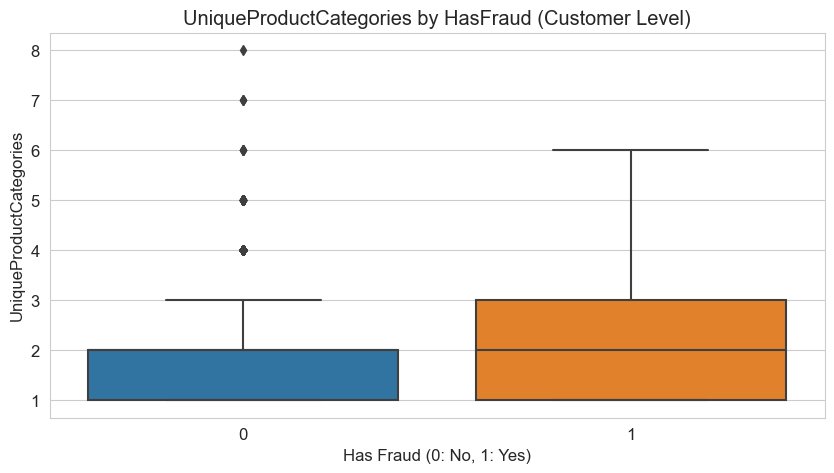

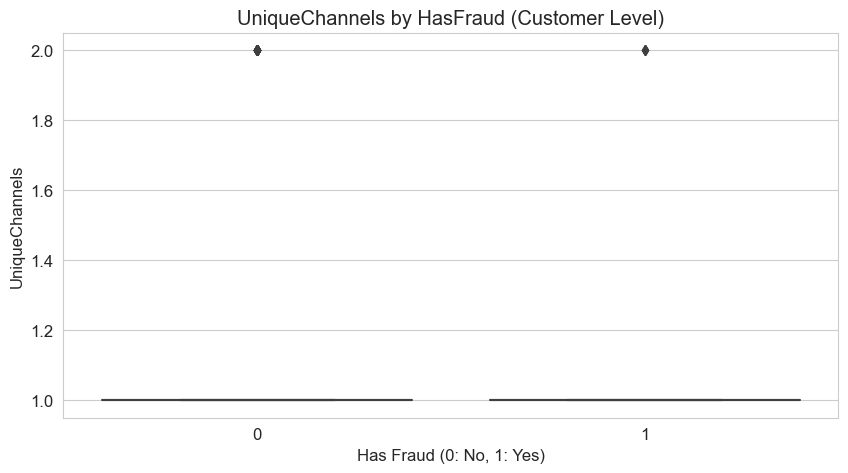

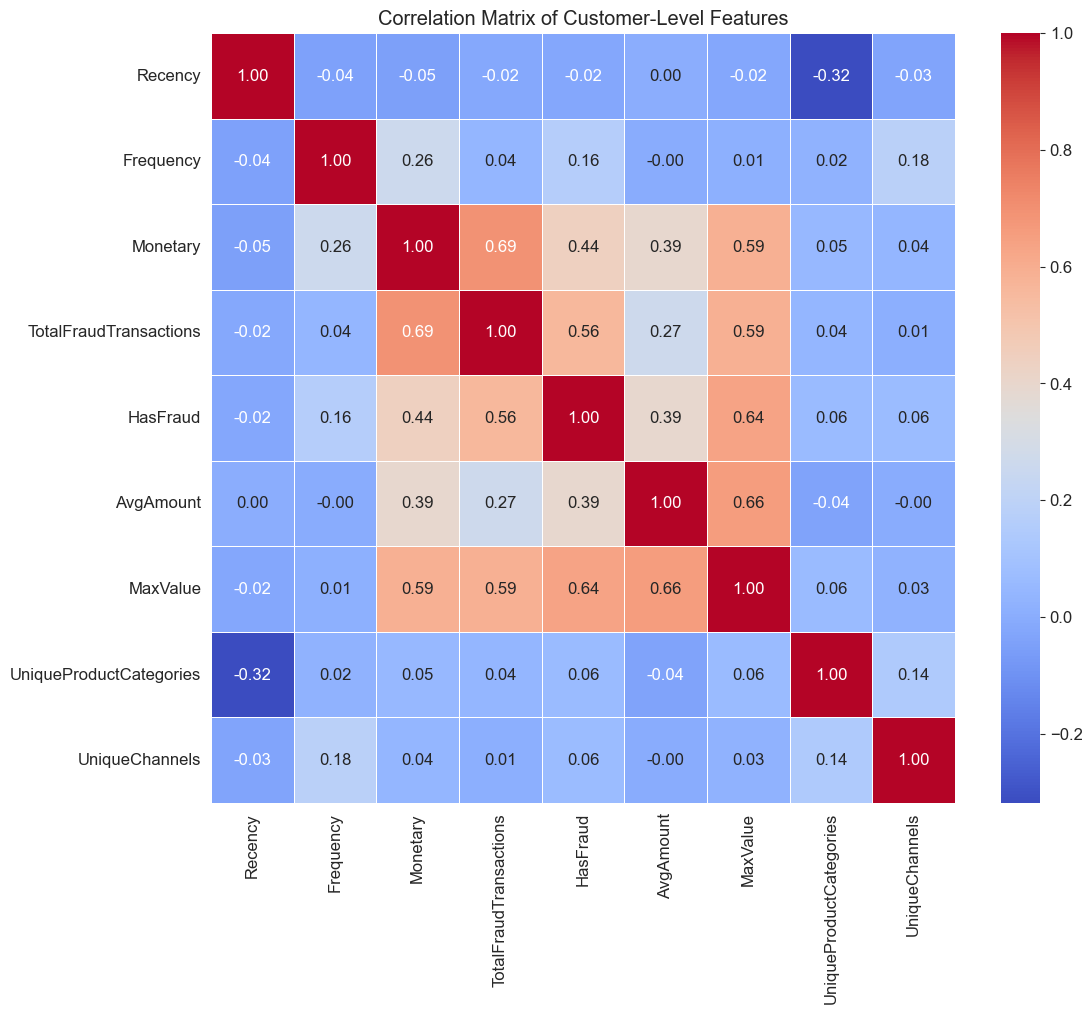


Correlation of Customer-Level Features with HasFraud:
HasFraud                   1.000000
MaxValue                   0.638542
TotalFraudTransactions     0.559846
Monetary                   0.441663
AvgAmount                  0.394149
Frequency                  0.162313
UniqueChannels             0.063044
UniqueProductCategories    0.061750
Recency                   -0.023793
Name: HasFraud, dtype: float64


In [15]:
# Analyze RFM features in relation to HasFraud
rfm_features = ['Recency', 'Frequency', 'Monetary', 'AvgAmount', 'MaxValue', 'UniqueProductCategories', 'UniqueChannels']
for col in rfm_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='HasFraud', y=col, data=customer_data)
    plt.title(f'{col} by HasFraud (Customer Level)')
    plt.xlabel('Has Fraud (0: No, 1: Yes)')
    plt.ylabel(col)
    plt.show()

# Correlation at customer level
customer_corr_matrix = customer_data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(customer_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Customer-Level Features')
plt.show()

print("\nCorrelation of Customer-Level Features with HasFraud:")
print(customer_data.corr(numeric_only=True)['HasFraud'].sort_values(ascending=False))